In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np 
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from kneed import KneeLocator
import matplotlib.cm as cm
import mlflow
import mlflow.sklearn

#### READ FEATURES DATASET

In [2]:
features_df = pd.read_csv("../dataset/model_features.csv")

# show the df
features_df.head()

,customer_id,recency_score,frequency_score,monetary_score,product_diversity,avg_rating,basket_size,tenure_days
0,15639,1,1,1,2,4.00,7094.5850,77
1,2839,1,3,5,1,5.00,186.7500,0
2,1038,1,1,1,2,3.25,3744.1775,77
3,14264,1,1,1,2,2.00,6240.1700,79
4,11827,1,1,1,2,3.50,7323.7100,189


In [3]:
# Save customer_id for later use
customer_ids = features_df['customer_id']

#### FEATURES SCALING

In [4]:
# Drop the customer_id before modeling
X = features_df.drop(columns='customer_id')

In [5]:
# Scale the features 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

#### DETERMINE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

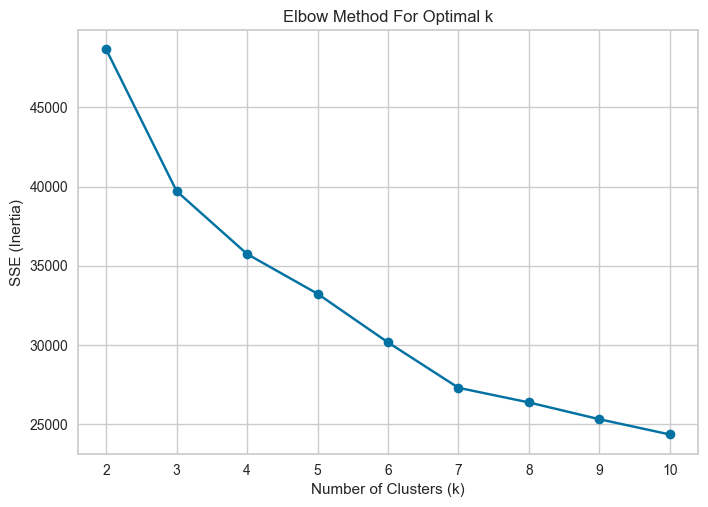

In [6]:
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
#plt.savefig('../image/Elbow_Method.png', dpi=300)
plt.show()

To determine the optimal number of clusters for customer segmentation, the Elbow Method was applied using the Sum of Squared Errors (SSE) as the evaluation metric. The resulting plot shows a steep decline in SSE from 2 to 4 clusters, after which the curve begins to level off. This indicates diminishing returns in reducing within-cluster variance as more clusters are added beyond this point. The distinct "elbow" in the plot occurs at k = 4, suggesting that segmenting the customers into four clusters offers a good balance between model complexity and explanatory power. Selecting this number of clusters helps avoid both underfitting (too few clusters) and overfitting (too many clusters), making it a statistically justified choice for downstream customer segmentation analysis.

#### SILHOUETTE SCORE PLOT WITH DIFFERENT K 

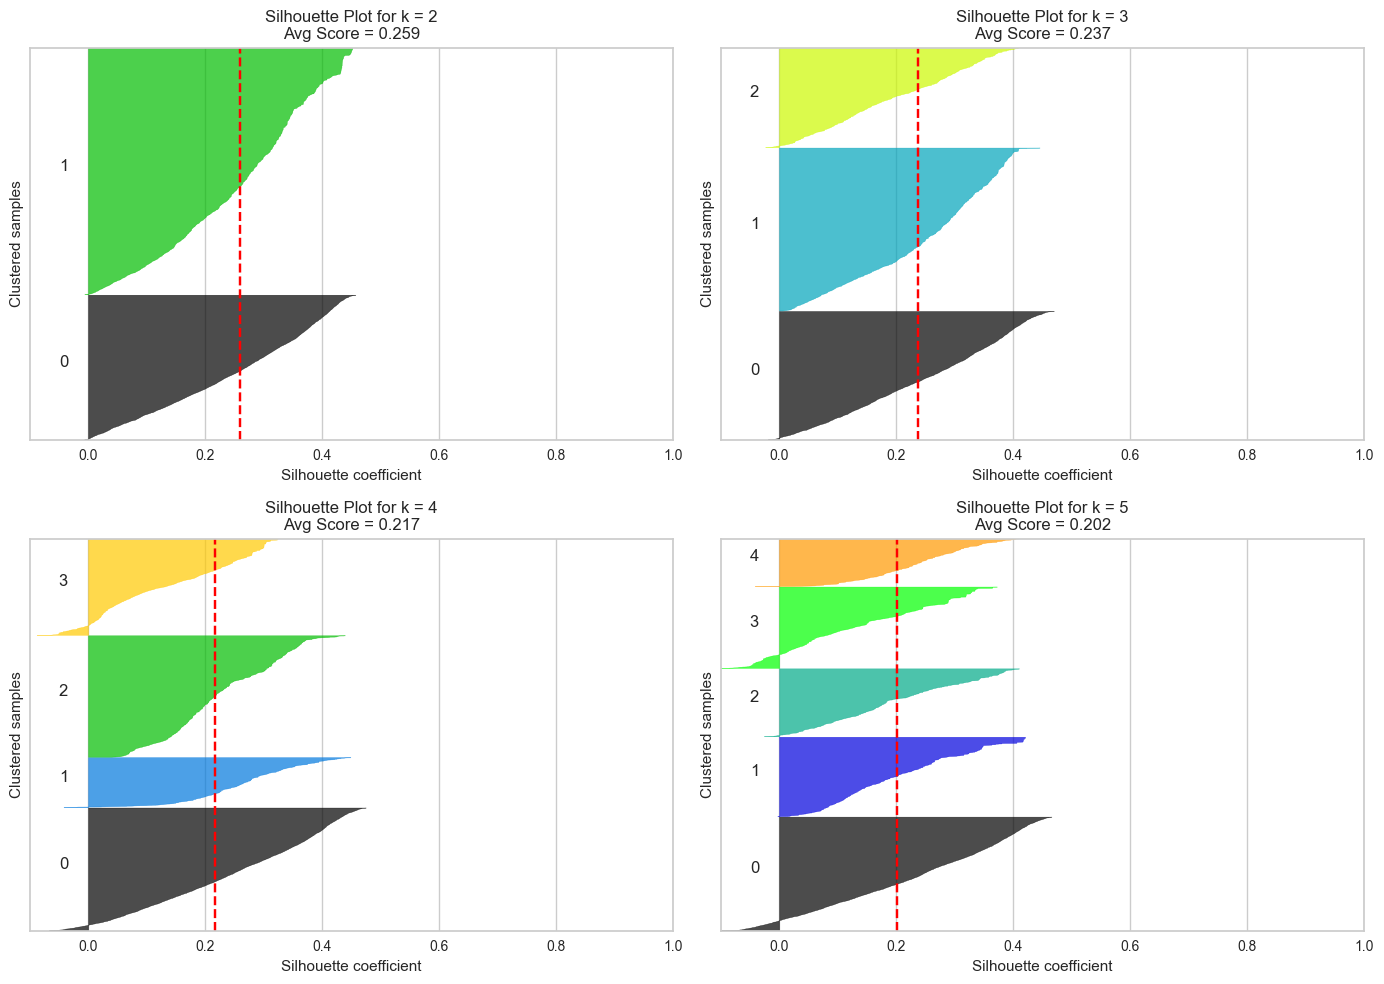

In [7]:
# Range of k values
k_values = [2, 3, 4, 5]

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Compute silhouette scores
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)
    
    # Prepare the plot
    ax = axes[idx]
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing between clusters

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette Plot for k = {k}\nAvg Score = {silhouette_avg:.3f}")
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Clustered samples")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(scaled_features)])
    ax.set_yticks([])

# Adjust layout
plt.tight_layout()
#plt.savefig('../image/SILHOUETTE_SCORE_PLOT.png', dpi=300)
plt.show()

#### CLUSTER SCATTER PLOR FOR MULTIPLE K (2,3,4,5) USING PCA

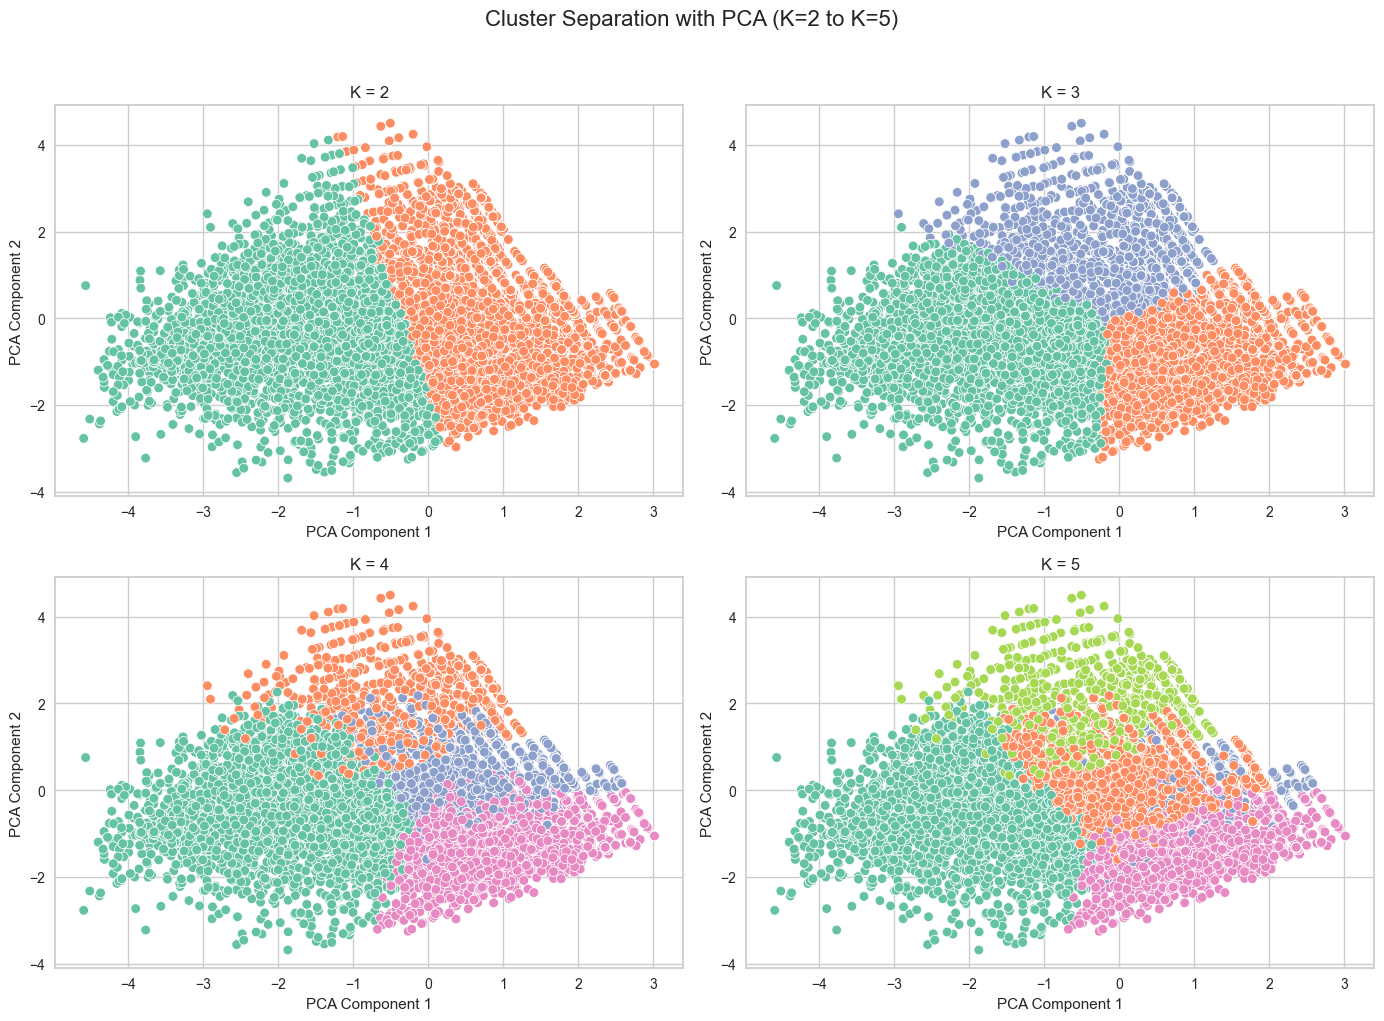

In [8]:
# Reduce to 2D with PCA for plotting
pca = PCA(n_components=2)
features_2d = pca.fit_transform(scaled_features)

# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

k_values = [2, 3, 4, 5]

for idx, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    
    ax = axes[idx]
    sns.scatterplot(
        x=features_2d[:, 0], y=features_2d[:, 1],
        hue=labels, palette='Set2', ax=ax, legend=False
    )
    ax.set_title(f"K = {k}")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

plt.suptitle("Cluster Separation with PCA (K=2 to K=5)", fontsize=16, y=1.02)
plt.tight_layout()
#plt.savefig("../image/Scatter_Different_K_PCA.png",  dpi=300)
plt.show()

#### LOGGED INTO MLFLOW TRACKING

In [18]:
# Start MLflow experiment
mlflow.set_experiment("electronic_rfm_clustering")
mlflow.set_tracking_uri("http://localhost:5001")

# Loop over candidate k values
for k in range(2, 6):
    with mlflow.start_run(run_name=f"kmeans_k={k}"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_features)

        # Compute silhouette
        sil_score = silhouette_score(scaled_features, labels)

        # Log parameters and metrics
        mlflow.log_param("n_clusters", k)
        mlflow.log_metric("silhouette_score", sil_score)
        mlflow.set_tag("developer", "Dario")

        # Log model if you want to keep it
        mlflow.sklearn.log_model(kmeans, artifact_path="model")

        print(f"k={k}, silhouette={sil_score:.3f}")

/Users/dazieldang/.venvs/py310/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


k=2, silhouette=0.259
k=3, silhouette=0.237
k=4, silhouette=0.217
k=5, silhouette=0.202


#### APPLY THE FINAL K = 3 

In [13]:
# Apply the final cluster = 3
kmeans = KMeans(n_clusters=3, random_state=42)
features_df['cluster'] = kmeans.fit_predict(scaled_features)

#### ANALYZE THE CHARACTERISTIC FOR EACH CLUSTER 

In [14]:
features_df.head()

,customer_id,recency_score,frequency_score,monetary_score,product_diversity,avg_rating,basket_size,tenure_days,cluster
0,15639,1,1,1,2,4.00,7094.5850,77,0
1,2839,1,3,5,1,5.00,186.7500,0,1
2,1038,1,1,1,2,3.25,3744.1775,77,0
3,14264,1,1,1,2,2.00,6240.1700,79,0
4,11827,1,1,1,2,3.50,7323.7100,189,0


In [15]:
cluster_summary = features_df.drop(columns='customer_id').groupby('cluster').mean().round(2)
cluster_summary.head()

,recency_score,frequency_score,monetary_score,product_diversity,avg_rating,basket_size,tenure_days
cluster,,,,,,,
0,2.32,1.58,1.97,2.23,3.02,3505.68,147.95
1,3.37,3.73,4.36,1.25,3.40,1342.90,33.76
2,3.26,3.63,2.12,1.14,2.73,5619.98,19.62


Cluster 0 → Passive Long-Tenure Customers

Cluster 1 → Loyal High-Value Champions 

Cluster 2 → New or Impulse Big Spenders

In [16]:
features_df['cluster'].value_counts()

cluster
1    3936
0    3100
2    2430
Name: count, dtype: int64

#### Cluster Profiling Report (K = 3)

The clustering analysis provides a comprehensive view of customer behaviors, revealing three distinct segments that differ not only in how much they spend but also in how they interact with the business. Cluster 1 stands out as the clear “champion” group, with strong recency scores (3.37), high frequency (3.73), and the highest monetary score of all clusters (4.36). These customers may purchase in smaller basket sizes (1,342.90 on average), but their consistent buying behavior makes them reliable revenue drivers. Their relatively short average tenure (33.76 days) suggests that they engage heavily from the start of their relationship with the company, a sign of high satisfaction and strong affinity. For marketers, this group is the backbone of customer lifetime value and should be the primary target for retention strategies, loyalty rewards, and upselling of premium products or services.

Cluster 2 paints a very different picture. These customers also demonstrate relatively high recency (3.26) and frequency (3.63) scores, but their monetary score is much lower (2.12). Instead of contributing consistent spending, they stand out for their extremely high basket size (5,619.98) and very short tenure (19.62 days). This suggests that they are either new customers making a one-time large purchase or impulse buyers who spend heavily but lack ongoing engagement. From a business perspective, this group is highly promising because they show strong initial purchasing power, but the challenge is preventing them from slipping away after their first few transactions. Personalized onboarding, targeted re-engagement, and subscription or bundle offers could help convert them into repeat customers, stabilizing their value over time.

Finally, Cluster 0 represents the least valuable segment. These customers have been with the company the longest (147.95 days) but exhibit the lowest frequency (1.58) and monetary (1.97) scores. Their recency score (2.32) also indicates that their purchases are not recent, highlighting a disengaged group that adds little incremental value despite their long tenure. In practical terms, this means they are not truly loyal but rather passive, low-spending customers. For this group, businesses must decide whether it is worth investing in reactivation campaigns—such as discounts, reminders, or re-targeting—or whether marketing resources would be better allocated to more promising clusters.

Taken together, these three clusters underscore the importance of nuanced customer segmentation. Cluster 1 requires ongoing retention investment, Cluster 2 should be nurtured toward loyalty, and Cluster 0 may warrant cost-conscious strategies. By recognizing these differences, businesses can tailor their marketing strategies to maximize revenue, improve customer experience, and reduce wasted effort on segments unlikely to deliver strong returns.

In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        9466 non-null   int64  
 1   recency_score      9466 non-null   int64  
 2   frequency_score    9466 non-null   int64  
 3   monetary_score     9466 non-null   int64  
 4   product_diversity  9466 non-null   int64  
 5   avg_rating         9466 non-null   float64
 6   basket_size        9466 non-null   float64
 7   tenure_days        9466 non-null   int64  
 8   cluster            9466 non-null   int32  
dtypes: float64(2), int32(1), int64(6)
memory usage: 628.7 KB
